In [119]:
# !pip install spotipy

In [120]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint

def load_config():
    global user_config
    stream = open('config.yaml')
    user_config = yaml.load(stream)

load_config()

token = util.prompt_for_user_token(user_config['username'], scope='playlist-modify-private,playlist-modify-public,user-modify-playback-state,user-read-playback-state', client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
if token:
    sp = spotipy.Spotify(auth=token)
    print(f'Token acquired: {token}')
else:
    print ("Can't get token for", user_config['username'])

/tmp/ipykernel_9774/2318982454.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  user_config = yaml.load(stream)


Token acquired: BQD5aDSM7IO1T4MkxaQZU5oZPbGlygXYS854MYKKrnoaxRFLdEQYJEi1NTWSFbfIzBmmKHNH41PTMoK30snpYx44mzsHlVArEbWlPqgntc3ce6T-M_eZLMniCHV4cTj1nfkKLtJbBx6ZsPjc3YTql1un847AOeB_n25sBwIn8EsshsyH2B0UzwkFjuEecymZpnLQVK5cxeuRFPr1WJRy_cQlIsCpvUqCj5ydu_PGSXYUnGzCTdSGYM0zX59NSAkxDEzo6ATbqvrPfQ


In [121]:
song_groupings = []

for i in range(0, 2):
    song_groupings.append(sp.playlist_items(user_config['playlist_id'], offset=i*100))


In [122]:
import re

artist_counts = {}
dates_added = {}

for grouping in song_groupings:
    for song in grouping['items']:
        artist = song['track']['artists'][0]['name']
        if artist in artist_counts:
            artist_counts[artist] += 1
        else:
            artist_counts[artist] = 1
        
        date = re.search(r"\d+-\d+", song['added_at']).group(0)
        if date not in dates_added:
            dates_added[date] = 1
        else:
            dates_added[date] += 1

# pprint(artist_counts)

print(f"Total artist references: {sum(artist_counts.values())}")
print(f"Total songs: {sum([len(grouping['items']) for grouping in song_groupings])}")
print(dates_added)

Total artist references: 186
Total songs: 186
{'2022-02': 24, '2022-03': 4, '2022-05': 7, '2022-06': 2, '2022-08': 4, '2022-09': 1, '2022-11': 1, '2023-03': 3, '2023-04': 6, '2023-06': 6, '2023-07': 6, '2023-08': 4, '2023-10': 14, '2023-11': 10, '2023-12': 5, '2024-01': 17, '2024-03': 2, '2024-04': 12, '2024-05': 21, '2024-06': 37}


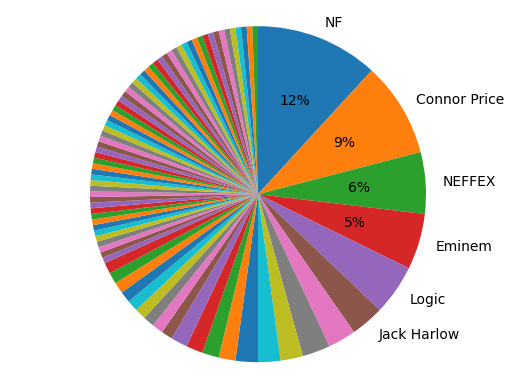

In [123]:
# create pie chart of artist counts
def autopct_more_than_threshold(pct):
    return ('%1.f%%' % pct) if pct > 5 else ''

import matplotlib.pyplot as plt

# sort in decreasing order
artist_counts = {k: v for k, v in sorted(artist_counts.items(), key=lambda item: item[1], reverse=True)}
labels = list(map(lambda x: x if artist_counts[x] > 5 else '', artist_counts.keys()))

plt.pie(artist_counts.values(), labels=labels, autopct=autopct_more_than_threshold, counterclock=False, startangle=90)
plt.axis('equal')
plt.show()

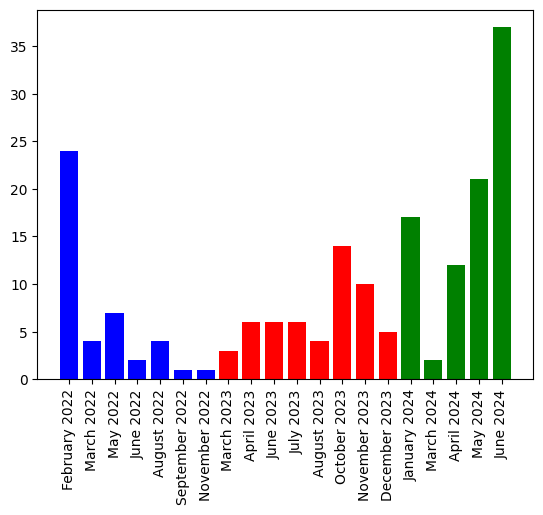

In [124]:
import calendar

# create bar graph of dates added
months = [calendar.month_name[int(date[-2:])] + ' ' + date[:4] for date in dates_added.keys()]

color_map = {
    '2022': 'blue',
    '2023': 'red',
    '2024': 'green',
}
colors = [color_map[month[-4:]] for month in months]
plt.bar(months, dates_added.values(), color=colors)
plt.xticks(rotation=90)
plt.show()

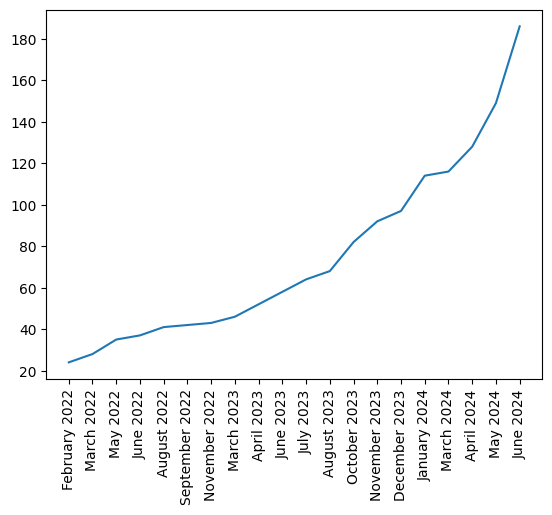

In [125]:
# create an accumaulation graph of dates added
accumulated_dates_added = {}
accumulated_count = 0

index = 0
for date in dates_added:
    accumulated_count += dates_added[date]
    accumulated_dates_added[months[index]] = accumulated_count

    index += 1

plt.plot(accumulated_dates_added.keys(), accumulated_dates_added.values())
plt.xticks(rotation=90)
plt.show()

In [126]:
# sp.pause_playback()

In [127]:
# sp.start_playback()

In [128]:
# sp.previous_track()

In [129]:
# sp.next_track()

In [130]:
pprint(sp.current_playback())

{'actions': {'disallows': {'resuming': True}},
 'context': {'external_urls': {'spotify': 'https://open.spotify.com/playlist/6jXha8BR9stmNI4KVv09B8'},
             'href': 'https://api.spotify.com/v1/playlists/6jXha8BR9stmNI4KVv09B8',
             'type': 'playlist',
             'uri': 'spotify:playlist:6jXha8BR9stmNI4KVv09B8'},
 'currently_playing_type': 'track',
 'device': {'id': 'f595be2f362872301a0dacfff00c506196453649',
            'is_active': True,
            'is_private_session': False,
            'is_restricted': False,
            'name': 'caleb-XPS-15-9500',
            'supports_volume': True,
            'type': 'Computer',
            'volume_percent': 100},
 'is_playing': True,
 'item': {'album': {'album_type': 'album',
                    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6fOMl44jA4Sp5b9PpYCkzz'},
                                 'href': 'https://api.spotify.com/v1/artists/6fOMl44jA4Sp5b9PpYCkzz',
                              

In [131]:
import requests
from bs4 import BeautifulSoup
import time

In [150]:
def lyrics_request(song_notation):
    server = 'genius.com'
    request = requests.get(f"https://{server}/{song_notation}")

    if request.status_code == 200:
        html_code = BeautifulSoup(request.text, features='html.parser')
        spans = html_code.find("div", {"data-lyrics-container": "true"}).find_all('span')

        if spans is None:
            print('Lyrics not found')
        else:
            lyrics = ''
            for span in spans:
                if span.get_text() != '':
                    lyrics += span.get_text() + '\n'
            return lyrics
    else:
        print('Request failed: status code', request.status_code)
        
    return None
    
def notation(raw_song_name):
    song_notations = []
    
    raw_song_name.replace('&' , 'and')

    raw_song_name.replace("'" , "")
    song_notations.append(raw_song_name)

    dashindexs = raw_song_name.find('---')
    song_notations.append(raw_song_name[:dashindexs + 1])

    return song_notations

def print_lyrics():
    current_song = sp.current_playback()
    artist = current_song['item']['artists'][0]['name']
    song_name = current_song['item']['name']

    song_url = '{}-{}-lyrics'.format(str(artist).strip().replace(' ', '-'),
                                    str(song_name).strip().replace(' ', '-'))

    print(song_url)

    lyrics = lyrics_request(song_url)
    print(lyrics)

print_lyrics()

Eminem-Lose-Yourself-lyrics
[Intro]
Look, if you had one shot or one opportunityTo seize everything you ever wanted in one momentWould you capture it or just let it slip?
[Verse 1]
His palms are sweaty, knees weak, arms are heavyThere's vomit on his sweater already, mom's spaghetti
He's nervous, but on the surface, he looks calm and readyTo drop bombs, but he keeps on forgettingWhat he wrote down, the whole crowd goes so loudHe opens his mouth, but the words won't come outHe's chokin', how? Everybody's jokin' nowThe clock's run out, time's up, over, blaow
Snap back to reality, ope, there goes gravity
Ope, there goes Rabbit, he choked, he's so madBut he won't give up that easy, no, he won't have itHe knows his whole back's to these ropes, it don't matter
He's dope, he knows that, but he's broke, he's so stagnant
He knows when he goes back to this mobile home,
Better go capture this moment and hope it don't pass him
You better lose yourself in the musicThe moment, you own it, you better 